In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [56]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [77]:
egg = pd.read_csv('/content/drive/MyDrive/뇌전증 프로젝트/archive/Epileptic Seizure Recognition.csv')
display(egg.head())
display(egg.tail())

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3
11499,X16.V1.210,29,41,57,72,74,62,54,43,31,...,-59,-25,-4,2,5,4,-2,2,20,4


In [78]:
egg = egg.drop('Unnamed', axis=1)
# 레이블 전처리
egg['y'] = egg['y'] - 1
egg.loc[(egg['y'] != 0) & (egg['y'] != 1), 'y'] = 2

e=egg

In [79]:
# 'egg' DataFrame에서 레이블 값이 0, 1, 2인 행의 개수 출력
print(len(e[e['y'] == 0]))
print(len(e[e['y'] == 1]))
print(len(e[e['y'] == 2]))

2300
2300
6900


In [80]:
# 1. 레이블이 0인 데이터 전처리
e_0 = e[e['y'] == 0].copy()
e_0_train = e_0[:1800].copy()
e_0_val = e_0[1800:].copy()

# 2. 레이블이 1인 데이터 전처리
e_1 = e[e['y'] == 1].copy()
e_1_train = e_1[:1800].copy()
e_1_val = e_1[1800:].copy()

# 3. 레이블이 2인 데이터 전처리
e_2 = e[e['y'] == 2].copy()
e_2_train = e_2[:5400].copy()
e_2_val = e_2[5400:].copy()

# 각 경우 1, 2, 3을 합쳐 훈련 세트와 검증 세트 형성
train = pd.concat([e_0_train, e_1_train, e_2_train])
val = pd.concat([e_0_val, e_1_val, e_2_val])

# 훈련 세트를 특성과 레이블로 나누기
X_train = train.drop(['y'], axis=1).copy()
y_train = train['y'].copy()

# 검증 세트의 특성과 레이블 나누기
X_val = val.drop(['y'], axis=1).copy()
y_val = val['y'].copy()

# 훈련셋과 검증셋의 shape 확인
print("훈련셋 : ", X_train.shape, y_train.shape)
print("검증셋 : ", X_val.shape, y_val.shape)


훈련셋 :  (9000, 178) (9000,)
검증셋 :  (2500, 178) (2500,)


In [81]:
# StandardScaler 라이브러리를 사용하여 노이즈가 있는 EEG 신호를 정규화
# 데이터 분포가 다양하기 때문에 정규분포로 정규화

from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
standard = StandardScaler()

# 훈련 세트와 검증 세트를 정규화
train_x_st = standard.fit_transform(X_train)
val_x_st = standard.transform(X_val)

In [62]:
# RobustScaler 라이브러리를 사용하여 노이즈가 있는 EEG 신호를 정규화
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

# 훈련 세트와 검증 세트를 RobustScaler
train_x_st = robust.fit_transform(X_train)
val_x_st = robust.transform(X_val)

In [82]:
# Data iter 함수 정의
def data_iter(batch_size, X, Y, L):
    # 인덱스를 받음
    num_examples = len(X)
    indices = list(range(num_examples))
    random.shuffle(indices)
    # 학습을 위해 batch_size 크기로 나눠진 데이터를 받음
    # 전체 데이터를 한 번 훑는다: 1 에폭
    # 각 특성에서 L개의 랜덤 숫자를 받기 위해 randint를 통해 L개의 숫자를 랜덤으로 받을 수 있도록 함
    # 특성 텐서와 레이블 텐서를 제로 텐서로 초기화하여 L에 해당하는 레이블을 받을 수 있도록 함
    # batch_indices에서 랜덤하게 섞인 인덱스를 슬라이싱을 통해 인덱스를 받음
    # 예) 데이터 개수 = 314, 1 = 310, batch_size = 100
    # 마지막 인덱스 310:314까지만 슬라이싱을 통해 받음
    for i in range(0, num_examples, batch_size):
        r1 = random.randint(0, 40)
        features = torch.zeros(batch_size, L)
        labels = torch.zeros(batch_size)
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        features = torch.tensor(np.array(train_x_st[batch_indices, r1: r1+L]))
        labels = torch.tensor(np.array(y_train.iloc[batch_indices])).to(torch.float32)
        yield features, labels

torch.Size([10, 100])
torch.Size([10])


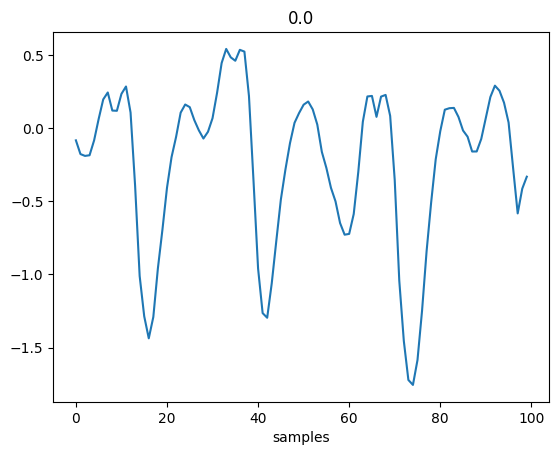

In [83]:
L = 100

for X_tr, y_tr in data_iter(10, train_x_st, y_train, L):
    print(X_tr.shape)
    print(y_tr.shape)

    for n in range(1):
        plt.plot(X_tr[n])
        plt.title(y_tr[n].item())  # y_tr은 텐서이므로 item()을 사용하여 값에 접근
        plt.xlabel('samples')
        plt.show()

    break

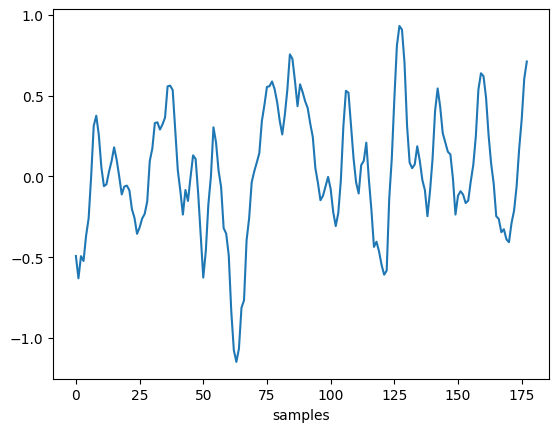

In [84]:
plt.plot(val_x_st[1495])
plt.xlabel('samples')
plt.show() #검증셋 호출

In [85]:
import torch.nn as nn

class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super(lstm, self).__init__()
        self.features = nn.Sequential(
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 20),
            nn.Linear(20, 40),
            nn.Linear(40, 20),
            nn.Linear(20, hidden_size),
            nn.Mish(),
            nn.Linear(hidden_size, hidden_size),
            nn.Mish(),
            nn.Dropout(0.3)
        )
        self.output = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        features, _ = self.features(x)
        output = self.classifier(features)
        output = self.output(output)
        return output

In [86]:
# input_size =15, hidden_size = 40, num_layer=2, outplut_layer=3 지정
m=lstm(15,40, 2, 3)
m.to(device)

lstm(
  (features): Sequential(
    (0): LSTM(15, 40, num_layers=2, batch_first=True, dropout=0.3)
  )
  (classifier): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=40, bias=True)
    (4): Mish()
    (5): Linear(in_features=40, out_features=40, bias=True)
    (6): Mish()
    (7): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=40, out_features=3, bias=True)
)

In [87]:
import torch.optim as optim

learning_rate = 0.001

# CrossEntropyLoss
loss = nn.CrossEntropyLoss(reduction='mean')
# AdamW optimizer를 사용하기 위해 AdamW 클래스를 사용합니다.
optimizer = optim.AdamW(m.parameters(), lr=learning_rate, betas=(0.9, 0.999))

epoch_tr_accuracy = []
epoch_vd_accuracy = []

In [88]:
import torch
import torch.nn as nn
import numpy as np

# Hyperparameters
learning_rate = 0.001
eval_interval = 1
num_epochs = 300
batch_size = 256
L = 120
early_stop_patience = 50  # 조기 종료의 인내 기간

# 모델 생성
m = lstm(input_size=15, hidden_size=40, num_layers=2, out_size=3)
m = m.to(device)

# 손실 함수 및 옵티마이저 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# 초기화
epoch_tr_accuracy = []
epoch_vd_accuracy = []
best_vd_accuracy = 0
patience_count = 0  # 조기 종료 인내 카운트 초기화

# 훈련 루프
for epoch in range(num_epochs):
    m.train()  # 훈련 모드로 전환

    Ncorrect = 0
    N = 0

    for X_tr, y_tr in data_iter(batch_size, train_x_st, y_train, L):
        X_tr = X_tr.view(len(X_tr), 8, 15).to(torch.float32)
        y_tr_pred = m(X_tr.to(device))
        y_tr_pred = y_tr_pred[:, -1, :]

        loss = loss_fn(y_tr_pred.cpu(), y_tr.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        Ncorrect += torch.sum(y_tr == torch.argmax(y_tr_pred.cpu(), dim=1)).numpy()
        N += len(X_tr)

    if epoch % eval_interval == 0:
        tr_accuracy = 100 * Ncorrect / N

        # 검증 데이터에 대한 정확도 계산
        m.eval()  # 평가 모드로 전환
        Ncorrect_vd = 0
        N_vd = 0

        for X_vd, y_vd in data_iter(len(val_x_st), val_x_st, y_val, L):
            X_vd = X_vd.view(len(val_x_st), 8, 15).to(torch.float32)
            with torch.no_grad():
                y_vd_pred = m(X_vd.to(device))
                y_vd_pred = y_vd_pred[:, -1, :]

            Ncorrect_vd += torch.sum(y_vd == torch.argmax(torch.nn.functional.softmax(y_vd_pred.cpu(), dim=1), dim=1)).numpy()
            N_vd += len(X_vd)

        vd_accuracy = 100 * Ncorrect_vd / N_vd

        if epoch % 5 == 0:
            print(f'epoch #{epoch}')
            print(f'accuracy of train set: {tr_accuracy} %')
            print(f'accuracy of valid set: {vd_accuracy} %')

        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

        # Early stopping 확인
        if vd_accuracy > best_vd_accuracy:
            best_vd_accuracy = vd_accuracy
            patience_count = 0
            # 모델 저장
            torch.save(m.state_dict(), 'best_model.pth')
        else:
            patience_count += 1
            if patience_count >= early_stop_patience:
                print(f'Early stopping at epoch #{epoch}')
                break

epoch #0
accuracy of train set: 56.84444444444444 %
accuracy of valid set: 0.0 %
epoch #5
accuracy of train set: 78.5 %
accuracy of valid set: 69.24 %
epoch #10
accuracy of train set: 78.5111111111111 %
accuracy of valid set: 69.88 %
epoch #15
accuracy of train set: 79.64444444444445 %
accuracy of valid set: 74.52 %
epoch #20
accuracy of train set: 79.02222222222223 %
accuracy of valid set: 76.04 %
epoch #25
accuracy of train set: 79.86666666666666 %
accuracy of valid set: 80.28 %
epoch #30
accuracy of train set: 79.97777777777777 %
accuracy of valid set: 77.16 %
epoch #35
accuracy of train set: 79.7 %
accuracy of valid set: 78.16 %
epoch #40
accuracy of train set: 79.74444444444444 %
accuracy of valid set: 76.8 %
epoch #45
accuracy of train set: 80.26666666666667 %
accuracy of valid set: 75.12 %
epoch #50
accuracy of train set: 80.73333333333333 %
accuracy of valid set: 74.04 %
epoch #55
accuracy of train set: 80.13333333333334 %
accuracy of valid set: 81.52 %
epoch #60
accuracy of tr

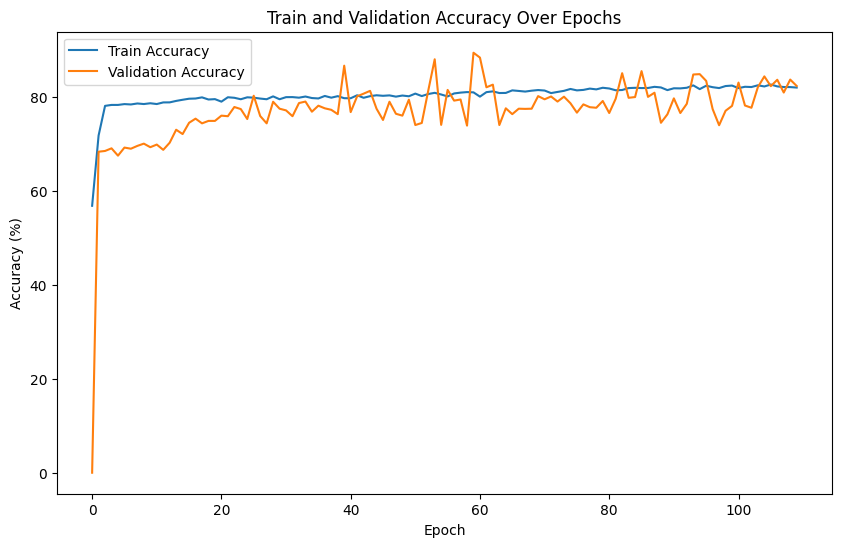

In [89]:
import matplotlib.pyplot as plt

# 훈련 정확도 및 검증 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(epoch_tr_accuracy, label='Train Accuracy')
plt.plot(epoch_vd_accuracy, label='Validation Accuracy')
plt.title('Train and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from enum import Enum

# 입력 크기(input_size) 설정
input_size = 15

# 검증 데이터에 대한 예측 결과 생성
y_hat_vd = np.array([])

# 검증 데이터의 특성(feature)만 정규화합니다. np.array 형식입니다.
dlist = val_x_st

# 검증 데이터의 실제 레이블(y_vd) 생성
y_vd = np.concatenate((
    np.zeros(len(val[val['y'] == 0])),
    np.ones(len(val[val['y'] == 1])),
    np.zeros(len(val[val['y'] == 2])) + 2
), axis=0).astype('int64')

# 정의된 신경망(m)은 15개의 입력을 받기 때문에 input_size를 15로 설정합니다.
# 각 데이터에 대해 가장 높은 확률의 인덱스를 받아오고, 그 결과를 y_hat_vd에 추가합니다.
for n in range(len(dlist)):
    a = dlist
    a = a[n]
    N = int(np.ceil(len(a) / input_size))
    a = np.pad(a, [0, N * input_size - len(a)])
    X = torch.Tensor(a).view(1, N, input_size)
    y_hat = m(X.to(device))
    y_hat = y_hat[:, -1, :]
    y_hat_cpu = y_hat.cpu()  # CUDA 디바이스에서 호스트 메모리로 복사
    y_hat_vd = np.append(y_hat_vd, torch.argmax(y_hat_cpu - nn.functional.softmax(y_hat_cpu, dim=1), dim=1))



Robust sclaler 적용

                    precision    recall  f1-score   support

Epileptic_Seizures       0.96      0.97      0.97       500
             Tumor       0.55      0.77      0.64       500
            Normal       0.91      0.79      0.84      1500

          accuracy                           0.82      2500
         macro avg       0.81      0.84      0.82      2500
      weighted avg       0.85      0.82      0.83      2500



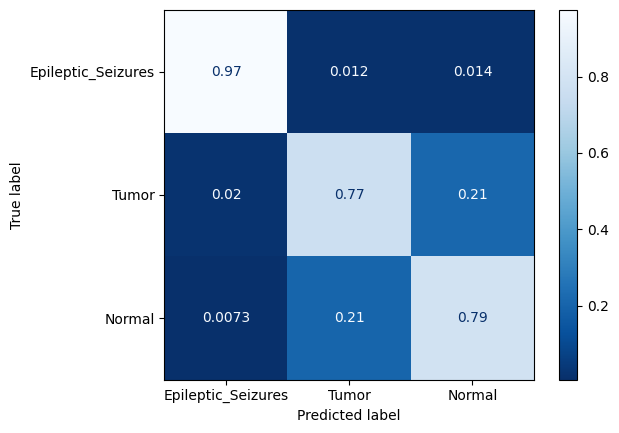

In [73]:
# 진단 결과를 나타내는 열거형(Enum) 정의
class Diagnosis(Enum):
    Epileptic_Seizures = 0
    Tumor = 1
    Normal = 2

# 분류 보고서(classification report) 및 혼동 행렬(confusion matrix) 출력
print(classification_report(
    y_vd,
    y_hat_vd,
    target_names=[d.name for d in Diagnosis]
))

cm = confusion_matrix(
    y_vd,
    y_hat_vd,
    normalize='true',
)

# 혼동 행렬을 시각화하여 출력
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1], cmap='Blues_r')

In [76]:
from sklearn.metrics import accuracy_score
import numpy as np

# 정확도 계산 및 출력
accuracy = accuracy_score(y_vd, y_hat_vd)
print(f'전체 정확도: {accuracy:.2f}')

# 각 클래스별 정확도 계산 및 출력
for i in range(len(Diagnosis)):
    class_total = np.sum(y_vd == i)
    class_accuracy = accuracy_score(y_vd == i, y_hat_vd == i)
    class_acc = 100 * class_accuracy if class_total != 0 else 0
    print(f'{Diagnosis(i).name} 클래스의 정확도: {class_acc:.2f}%')


전체 정확도: 0.82
Epileptic_Seizures 클래스의 정확도: 98.64%
Tumor 클래스의 정확도: 82.68%
Normal 클래스의 정확도: 82.60%


standard sclaler 적용

                    precision    recall  f1-score   support

Epileptic_Seizures       0.95      0.97      0.96       500
             Tumor       0.50      0.60      0.55       500
            Normal       0.86      0.80      0.83      1500

          accuracy                           0.79      2500
         macro avg       0.77      0.79      0.78      2500
      weighted avg       0.81      0.79      0.80      2500



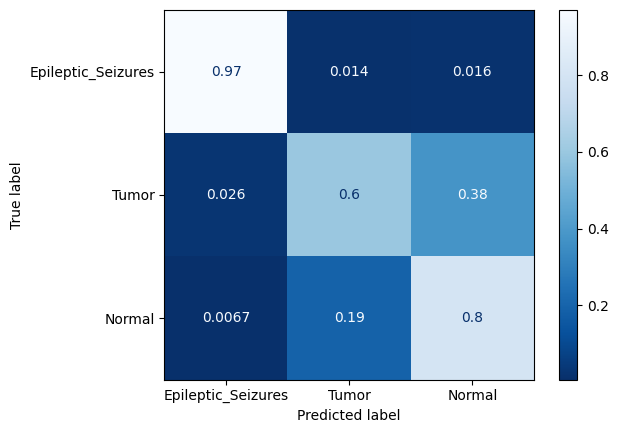

In [91]:
# 진단 결과를 나타내는 열거형(Enum) 정의
class Diagnosis(Enum):
    Epileptic_Seizures = 0
    Tumor = 1
    Normal = 2

# 분류 보고서(classification report) 및 혼동 행렬(confusion matrix) 출력
print(classification_report(
    y_vd,
    y_hat_vd,
    target_names=[d.name for d in Diagnosis]
))

cm = confusion_matrix(
    y_vd,
    y_hat_vd,
    normalize='true',
)

# 혼동 행렬을 시각화하여 출력
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1], cmap='Blues_r')

In [92]:
from sklearn.metrics import accuracy_score
import numpy as np

# 정확도 계산 및 출력
accuracy = accuracy_score(y_vd, y_hat_vd)
print(f'전체 정확도: {accuracy:.2f}')

# 각 클래스별 정확도 계산 및 출력
for i in range(len(Diagnosis)):
    class_total = np.sum(y_vd == i)
    class_accuracy = accuracy_score(y_vd == i, y_hat_vd == i)
    class_acc = 100 * class_accuracy if class_total != 0 else 0
    print(f'{Diagnosis(i).name} 클래스의 정확도: {class_acc:.2f}%')

전체 정확도: 0.79
Epileptic_Seizures 클래스의 정확도: 98.48%
Tumor 클래스의 정확도: 80.04%
Normal 클래스의 정확도: 80.12%


처음에 클래스가 5개인데 뇌전증환자에 대한
-> 클래스 0(뇌전증), 2(뇌종양) , 3~5(건강) 이여서
건강 클래스를 하나로 통합했었음

뇌파 데이터에는 심장박동, 전극의 움직임 등 노이즈가 있으므로 이를 잡기위해 robust scaler, standard scaler을 적용해본 결과 roubst scaler가 노이즈에 대해 우세했으므로 **robust scaler 결과 관측**

Epileptic_Seizures(0) : 뇌전증       
             Tumor(1) : 뇌종양         
            Normal(2) : 건강    
confusion matrix결과 바탕으로 class별 정확도 확인해본결과
결과적으로 **뇌전증(0) 98%로 정확하게 예측을 했음**
**종양(1)과 건강(2)도 82%로 나름 정확하게 예측함**

그러나 뇌종양(1)과 건강(2) 점수는 상대적으로 조금 낮음
아마 신호의 파형이 뇌종양과 건강 클래스가 비슷한 부분때문에 뇌종양 클래스에 대해 제대로 예측해지 못했을거라 생각함

->종양만을 가지고 있는 경우 상대적으로 정확도가 조금 낮음
뇌파 신호 파형이 비슷한 건강클래스에서 데이터가 상대적으로 많아서 어느정도 불균형함
-> 정확도(accuarcy)보다 f1-score에 비중을 두고 파악하는게 좋을듯함

-> 정상클래스를 통합하면서 생긴 상대비율 차이가 간질발작을 예측하는데는 문제가 없지만, 뇌종양을 예측하는데는 영향을 미쳤음


